In [2]:
!git clone https://github.com/SilasK/CMGM

Cloning into 'CMGM'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 34 (delta 2), reused 30 (delta 1), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [4]:
!ls CMGM

data  Figures  notebooks  README.md


In [5]:
!ln -s CMGM/notebooks/helper_scripts .

In [8]:
!pip install scikit-bio

     |████████████████████████████████| 8.4 MB 11.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-bio: filename=scikit_bio-0.5.6-cp37-cp37m-linux_x86_64.whl size=1456847 sha256=9ef5b197693710841d4de47c80ce89db27f8da75837cc553921647af453a5a83
  Stored in directory: /root/.cache/pip/wheels/7e/fa/86/a8b3b3b1187f0b0997fca40cdb7dd0d81a57ff061010e4464d
  Created wheel for hdmedians: filename=hdmedians-0.14.2-cp37-cp37m-linux_x86_64.whl size=453180 sha256=97db340cf05107ffbc57a342366cfba202d7832c4f994b8a47a26dd33a2317a5
  Stored in directory: /root/.cache/pip/wheels/56/5d/28/fb40426fbf6a8c3af88376a227130bbdf81e00177123e1398e
Successfully built scikit-bio hdmedians


In [9]:
%pylab inline
import pandas as pd
import seaborn as sns


from helper_scripts import MetaTable
import helper_scripts as hs

from scipy.stats import ttest_ind


Populating the interactive namespace from numpy and matplotlib


In [10]:
module_table= 'https://ezmeta.unige.ch/CMGM/v1/CMGM_tables/kegg_modules.tsv'
annotations_excel= 'https://ezmeta.unige.ch/CMGM/v1/CMGM_tables/metabolism_summary.xlsx'
taxonomy_file = 'https://ezmeta.unige.ch/CMGM/v1/CMGM_tables/curated_taxonomy.tsv'

### Load metadata

We have the folowing number of samples from cold exposed (CE) and control mice at room temperature (RT) form two gut locations (Feces and Cecum).

We will concentrate on the Fecal samples

In [12]:
metadata= pd.read_table('CMGM/data/metadata_cold_exposure.tsv',index_col=0)
display(metadata.groupby(['Source','Group']).size())
metadata= metadata.query('Source=="Feces"')

Source  Group
Cecum   CE       8
        RT       7
Feces   CE       7
        RT       6
dtype: int64

### Load taxonomy

In [13]:

# load green geens froamted taxonomy
Tax= hs.tax2table(pd.read_table('https://ezmeta.unige.ch/CMGM/v1/CMGM_tables/curated_taxonomy.tsv',
                               index_col=0,squeeze=True,header=None)
                 )

Tax.head()

,kindom,phylum,class,order,family,genus,species
0,,,,,,,
MGG00015,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,COE1,COE1 sp002358575
MGG00022,Bacteria,Desulfobacterota,Desulfovibrionia,Desulfovibrionales,Desulfovibrionaceae,Mailhella,Mailhella sp003150275
MGG00129,Bacteria,Firmicutes_A,Clostridia_A,Christensenellales,CAG-552,MGG22630,MGG22630 MGG00129
MGG00141,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,MGG00141,MGG00141 MGG00141
MGG00234,Bacteria,Firmicutes_A,Clostridia_A,Christensenellales,Borkfalkiaceae,UBA11940,UBA11940 MGG00234


### Load abundance data

The median coverage is used to calculate relative abundance. But for the differencial abundance testing we use centered log ratio of the raw coverage values, because sequencing data is compositional. See more on [compostional data analyis](https://en.wikipedia.org/wiki/Compositional_data)

In [15]:
counts_all= pd.read_table('CMGM/data/counts_genomes.tsv.gz',index_col=0)

coverage_all= pd.read_table('CMGM/data/median_coverage_genomes.tsv.gz',index_col=0)


In [16]:

# a species needs to be at least 50% covered in one sample
coverage= coverage_all.loc[metadata.index,coverage_all.max()>0.5]

#calcualte relative abundance of genomes
relab= (coverage.T / coverage.sum(1)).T *100

counts= counts_all.loc[metadata.index,coverage.columns]

# transform counts with centered log2 ratio (for more info see link above)
clr_data= hs.clr(counts,log=np.log2)

## Create metadata to calulate differencial abundance

In [17]:

def calulate_statistics(data):
    stats= data.groupby(metadata.Group).mean().T.rename(columns= lambda s: 'Mean '+s)
    # we use welch test for statistical analysis
    
    two_groups= tuple(d for _,d in  data.groupby(metadata.Group))
    assert len(two_groups)==2, "grouping of data in two groups failed"
    
    _, stats['Pvalue']=   ttest_ind(*two_groups,equal_var=False)
    # correct for multiple testing
    stats['pBH']= hs.Significance.correct_pvalues_for_multiple_testing( stats.Pvalue)


    return stats

genom_stats= calulate_statistics(clr_data)

# as the data in log2 the difference between the means is the log FC
genom_stats['logFC']= genom_stats['Mean CE'] - genom_stats['Mean RT']
genom_stats.sort_values('logFC')

genom_stats['logP'] = -genom_stats.pBH.apply(np.log10)
genom_stats= genom_stats.join(Tax[['phylum','family','species']])

,Mean CE,Mean RT,Pvalue,pBH,logFC,logP,phylum,family,species
MGG05372,-4.420411,1.328276,1.940892e-06,0.000398,-5.748686,3.400245,Firmicutes_A,Lachnospiraceae,Eubacterium_F MGG05372
MGG22148,-2.764181,5.207787,3.962115e-06,0.000406,-7.971969,3.391349,Bacteroidota,Muribaculaceae,UBA7173 MGG22148
MGG29829,0.205818,7.558474,3.718736e-06,0.000406,-7.352656,3.391349,Bacteroidota,Muribaculaceae,UBA7173 sp001689685
MGG49980,-8.590107,6.336969,3.453149e-07,0.000142,-14.927076,3.849001,Verrucomicrobiota,Akkermansiaceae,Akkermansia muciniphila


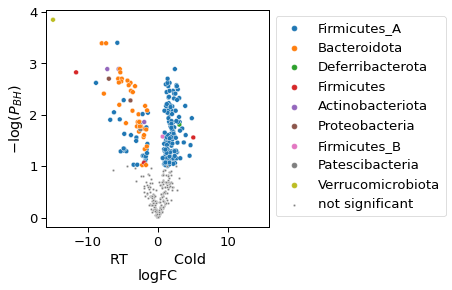

In [18]:
hs.plotting.plotting_Setup(save_dpi=300)

f= plt.figure(figsize=(4,4))


hue= genom_stats.phylum.copy()    
hue.loc[genom_stats.logP<1]=None 

ax=sns.scatterplot(y='logP',x= 'logFC' ,data=genom_stats,
               hue= hue, alpha=1)

ax=sns.scatterplot(y='logP',x= 'logFC' ,data=genom_stats.loc[hue.isnull()],
                   color='grey',marker='.',
                   label='not significant'
               )


ax.set_xlabel('RT'+' '*10+'Cold'+'\nlogFC')
ax.legend(bbox_to_anchor=(1,1)) 
ax_lim= np.abs(ax.get_xlim()).max()
ax.set_xlim([-ax_lim,ax_lim])
ax.set_ylabel('$-\log(P_{BH})$');




genom_stats.query('logP>3')



## load modules

In [19]:
module_table= pd.read_table(module_table, index_col=[1,2])
module_matrix= module_table.step_coverage.unstack(fill_value=0)
module_matrix= module_matrix.loc[:, module_matrix.max()>0.1]

module_names = module_table.droplevel(0).module_name.drop_duplicates()

In [20]:
# Define module threshold by a threshold

threshold= 0.75

module_presence = (module_matrix > threshold) *1
#drop all 0 modules
module_presence= module_presence.loc[:,module_presence.max()>0]




/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 0.98, 'Module coverage above threshold')

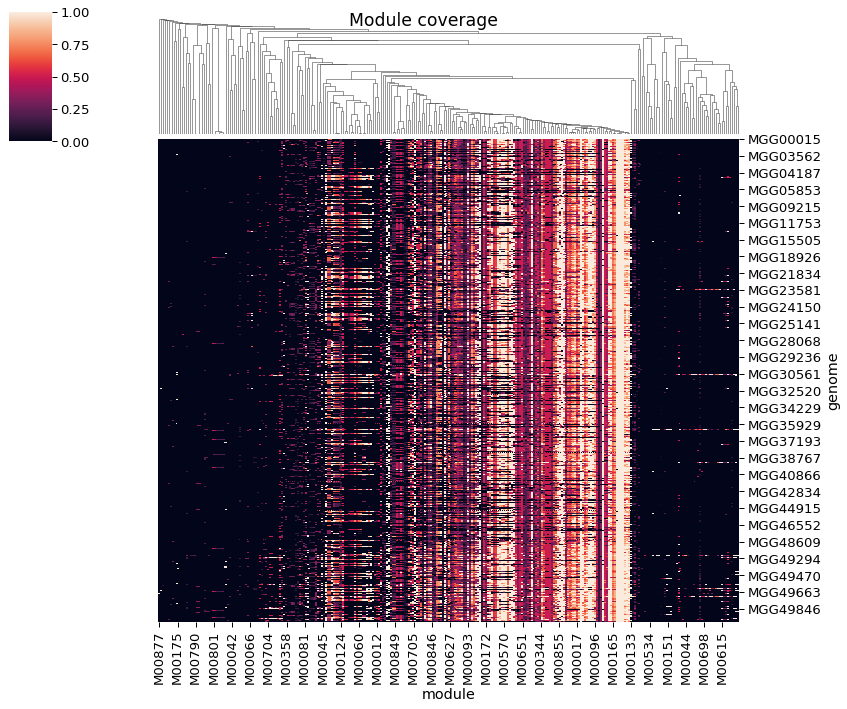

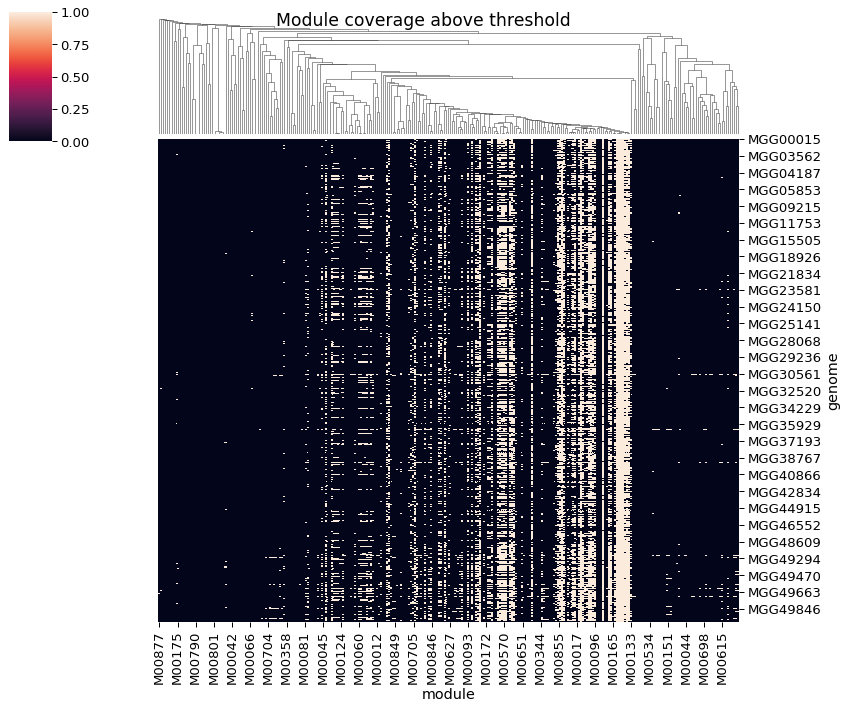

In [21]:
cgi= sns.clustermap(module_matrix,metric='cosine',figsize=(12,10),row_cluster=False)

cgi.fig.suptitle('Module coverage')

cgi_bin=sns.clustermap(module_matrix> threshold,
                   figsize=(12,10),
                   row_cluster=False,
                       col_linkage= cgi.dendrogram_col.linkage
                  )
cgi_bin.fig.suptitle('Module coverage above threshold')


As no modules for short-chain-fatty acids are in Kegg we creat our own. 


In [22]:
#this can take some time
A, annotation_description= hs.read_dram_annotation_summary(annotations_excel)

100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


In [23]:




paths_for= {'Propanoate' : [('K19697','K00932'),'K01026','K01895','K01908'],
            'Butyrate': [('K01034','K01034'),('K00929','K00634')] ,
            'Acetate': ['K01067','K00156','K00925','K01512','K00467'],
            'Lactate': ['K00016']
           }
                     
                    
F = pd.DataFrame(index=A.index)

for function in paths_for:

    F[function]= False

    for ko_list in  paths_for[function]:

        if type(ko_list)==str:
            ko_list = [ko_list]

            
        F[function] |= A.reindex(columns=ko_list,fill_value=False).all(1)

module_presence= pd.concat( (module_presence,F.astype(int)),axis=1)

for scfa in F.columns:
    module_names[scfa]= scfa+' metabolism'

## Calculate module abundance
calulate module abundance as the sum of relative abundance of species containing the module
We do this with a matrix multiplication

In [24]:


module_abundance = relab @ module_presence.loc[relab.columns]
module_abundance= module_abundance.loc[:,module_abundance.max()>0]

In [25]:
stats= calulate_statistics(module_abundance)

stats['Name']= module_names

stats['log2FC']= - stats[['Mean CE', 'Mean RT']].apply( lambda x: np.log2(x+1e-5) ).diff(axis=1).iloc[:,1]

In [26]:
hit_table= stats.query("pBH<0.01 & abs( log2FC ) >1").sort_values('log2FC')
hit_table

Group,Mean CE,Mean RT,Pvalue,pBH,Name,log2FC
M00086,10.154993,40.548469,0.000729,0.001582,"beta-Oxidation, acyl-CoA synthesis",-1.997457
M00060,17.400375,55.639032,0.000305,0.001000,"KDO2-lipid A biosynthesis, Raetz pathway, LpxL...",-1.676978
M00577,17.850249,56.648027,0.000346,0.001000,"Biotin biosynthesis, BioW pathway, pimelate =>...",-1.666081
M00573,17.850249,56.648027,0.000346,0.001000,"Biotin biosynthesis, BioI pathway, long-chain-...",-1.666081
M00123,17.850249,56.648027,0.000346,0.001000,"Biotin biosynthesis, pimeloyl-ACP/CoA => biotin",-1.666081
M00052,20.773332,62.880317,0.000250,0.000959,"Pyrimidine ribonucleotide biosynthesis, UMP =>...",-1.597875
M00127,24.414901,64.710230,0.000245,0.000959,"Thiamine biosynthesis, AIR => thiamine-P/thiam...",-1.406232
M00153,28.372614,74.841051,0.000192,0.000959,Cytochrome bd ubiquinol oxidase,-1.399330
M00045,22.421983,57.774767,0.000139,0.000887,"Histidine degradation, histidine => N-formimin...",-1.365525
M00011,26.580169,65.619563,0.000154,0.000930,"Citrate cycle, second carbon oxidation, 2-oxog...",-1.303775


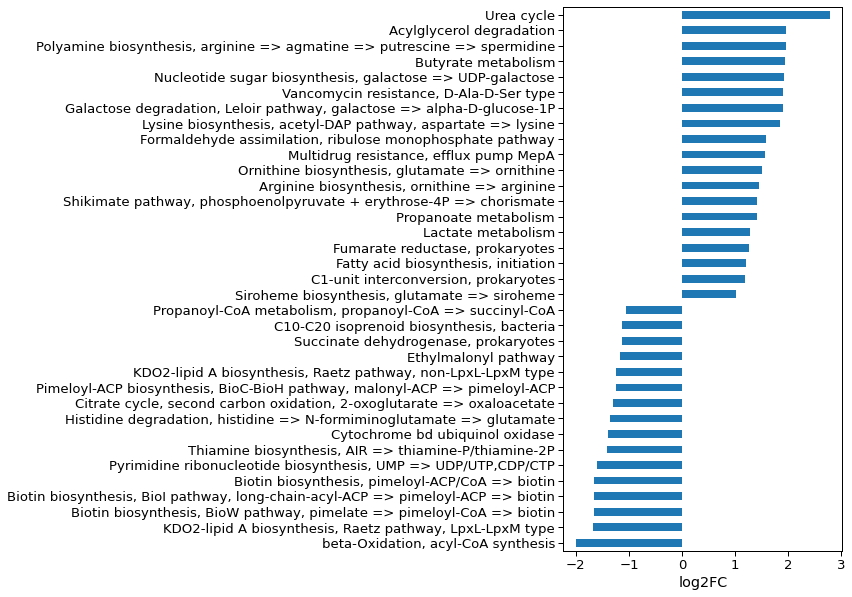

In [27]:
ax=hit_table.log2FC.plot.barh(figsize=(5,10))
ax.set_yticklabels(hit_table.Name);
ax.set_xlabel('log2FC');

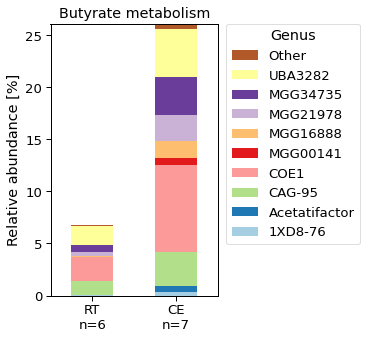

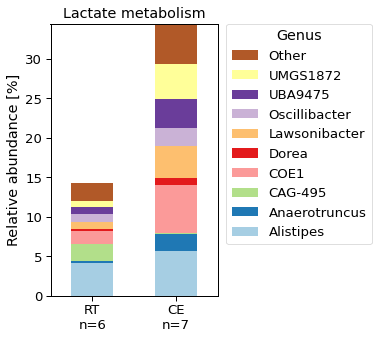

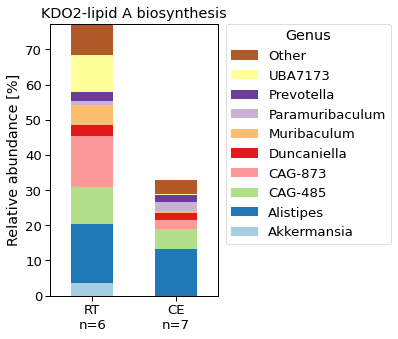

In [28]:


level='genus'
for module_of_interest in ['Butyrate','Lactate', 'M00866', ]:


    genomes_for_module= module_presence[module_of_interest]==1
    average_abundance= relab.loc[:,genomes_for_module].groupby(Tax[level],axis=1).sum()

    ax=hs.bubble.MeanGroup_Barplot(average_abundance,metadata.Group,filtervalue=10,order=['RT','CE'],figsize=(3, 5))

    ax.set_title(module_names.loc[module_of_interest].split(',')[0],loc='center')
    ax.set_ylabel('Relative abundance [%]')
    ax.legend_.set_title(level[0].upper()+level[1:])
    plt.show()
